In [21]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [22]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

def get_blockerrors_pyblock_nanskip(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)[0]
 #           opt_block = reblock_data[opt]
 #           be = opt_block[4]
            if (math.isnan(opt)):
                be_max=0
                for i in range(0, len(reblock_data)):
                    be = reblock_data[i][4]
                    if (be > be_max) :
                        be_max=be
            else:
                be = reblock_data[opt][4]
            
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf

def get_blockerror_pyblock_max(Data):
    average=np.average(Data)
    if (average!=0) and (average!=1):
        reblock_data = pyblock.blocking.reblock(Data)
        be_max=0
        for i in range(0,len(reblock_data)): 
            be=reblock_data[i][4]
            if(be > be_max):
                be_max=be
    else:
        be=0
    return average,float(be)

def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E, dsspH, dsspE

def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)

# Functions to Calculate Aromatic Stacking Interactions

def find_plane_normal(points):

    N = points.shape[0]
    A = np.concatenate((points[:, 0:2], np.ones((N, 1))), axis=1)
    B = points[:, 2]
    out = lstsq(A, B, rcond=-1)
    na_c, nb_c, d_c = out[0]
    if d_c != 0.0:
        cu = 1./d_c
        bu = -nb_c*cu
        au = -na_c*cu
    else:
        cu = 1.0
        bu = -nb_c
        au = -na_c
    normal = np.asarray([au, bu, cu])
    normal /= math.sqrt(dot(normal, normal))
    return normal


def find_plane_normal2(positions):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    # Use Ligand IDs 312, 308 and 309 to check direction
    # [304 305 306 307 308 309 310 311 312 313]
    v1 = positions[0]-positions[1]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[2]-positions[1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def find_plane_normal2_assign_atomid(positions, id1, id2, id3):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    v1 = positions[id1]-positions[id2]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[id3]-positions[id1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def get_ring_center_normal_assign_atomid(positions, id1, id2, id3):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2_assign_atomid(positions, id1, id2, id3)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def get_ring_center_normal_(positions):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2(positions)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


def get_ring_center_normal_trj_assign_atomid(position_array, id1, id2, id3):
    length = len(position_array)
    centers = np.zeros((length, 3))
    normals = np.zeros((length, 3))
    centers_normals = np.zeros((length, 2, 3))
    print(np.shape(length), np.shape(centers), np.shape(normals))
    for i in range(0, len(position_array)):
        center, normal = get_ring_center_normal_assign_atomid(
            position_array[i], id1, id2, id3)
        centers_normals[i][0] = center
        centers_normals[i][1] = normal
    return centers_normals

# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    print("nh_donors", nh_donors)
    for i in nh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    oh_donors = get_donors('O', 'H')
    print("oh_donors", oh_donors)
    for i in oh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    sh_donors = get_donors('S', 'H')
    print("sh_donors", sh_donors)
    for i in sh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    for i in lig_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)


def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return

def bound_frac_kd(box_len,n_reps,contact_matrix=[],trj_frames=[]):
    
    Box_L = box_len
    # Convert nM to meters for Box_V in M^3
    Box_V = (Box_L*10**-9)**3
    # Convert Box_V to L
    Box_V_L = Box_V*1000
    #Concentraion in Mols/L
    Concentration = 1/(Box_V_L*(6.023*10**23))
    #print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)
    OUT=[]
    for i in range(n_reps):

        contact_rows = np.sum(contact_matrix[int(trj_frames[str(i)][0]):int(trj_frames[str(i)][1])], axis=1)
        bf, bf_be = get_blockerror_pyblock(np.where(contact_rows > 0, 1, 0))
    
        upper = bf+bf_be
        KD = Kd_calc(bf, Concentration)
        KD_upper = Kd_calc(upper, Concentration)
        KD_error = KD-KD_upper
    
        kd=np.round(KD*1000,4)
        kde=np.round(KD_error*1000,4)
    
        OUT.append([bf, bf_be, kd, kde])
    
    OUT=np.array(OUT)
    
    return OUT

def vec_angles(trj,atom_indices=[]):
    
    #Get xyz co-ordinates
    xyz=[]
    for  atom_idx in atom_indices :
        a=[]
        for frame_idx in range(trj.n_frames):

            a.append(trj.xyz[frame_idx, atom_idx,:].astype(float))
        xyz.append(a)    

    xyz=np.array(xyz)
    xyz.shape

    #Define vectors with 2nd atom as starting point
    V=[]
    v1=xyz[0]-xyz[1]
    v2=xyz[2]-xyz[1]
    V.append(v1)
    V.append(v2)

    #Compute angles between two vectors
    angles=[]
    for i in range(trj.n_frames):
    
        a=np.rad2deg(np.arccos(np.dot(V[0][i],V[1][i])/
                               (np.sqrt(np.dot(V[0][i],V[0][i])*np.dot(V[1][i],V[1][i])))))
        
        angles.append(a)
    
    angles=np.array(angles)
    
    return angles

def norm_weights(file_name):

    colvar=np.loadtxt(file_name,comments=['#','@'])
    num_cvs=len(colvar[0])-1



    kt=2.494339
    w=np.exp((colvar[:,num_cvs]/kt))


    max_=np.sum(w)
    w_norm=w/max_

    return num_cvs, w, w_norm

In [23]:
file_1='/home/jaya/work/analysis_trajectories/p53/meta_D_metaI/colvar.dat'
num_cvs, weights, weights_norm = norm_weights(file_1)
print("No of CV's :", num_cvs-1)
print(np.sum(weights_norm))

No of CV's : 6
0.9999999999999999


In [24]:
out_dir='/home/jaya/work/analysis_trajectories/p53/meta_D_metaI/data/'

In [25]:

pdb = '/home/jaya/work/analysis_trajectories/p53/meta_D_metaI/pbc.pdb'
traj='/home/jaya/work/analysis_trajectories/p53/meta_D_metaI/pbc.xtc'

trj = md.load(traj, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology

print(trj.n_frames)



108821


In [26]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 926

Number of residues: 61

Number of protein residues: 61

Number of frames: 108821

sequence:  [MET1, GLU2, GLU3, PRO4, GLN5, SER6, ASP7, PRO8, SER9, VAL10, GLU11, PRO12, PRO13, LEU14, SER15, GLN16, GLU17, THR18, PHE19, SER20, ASP21, LEU22, TRP23, LYS24, LEU25, LEU26, PRO27, GLU28, ASN29, ASN30, VAL31, LEU32, SER33, PRO34, LEU35, PRO36, SER37, GLN38, ALA39, MET40, ASP41, ASP42, LEU43, MET44, LEU45, SER46, PRO47, ASP48, ASP49, ILE50, GLU51, GLN52, TRP53, PHE54, THR55, GLU56, ASP57, PRO58, GLY59, PRO60, ASP61]

residue names:  ['MET', 'GLU', 'GLU', 'PRO', 'GLN', 'SER', 'ASP', 'PRO', 'SER', 'VAL', 'GLU', 'PRO', 'PRO', 'LEU', 'SER', 'GLN', 'GLU', 'THR', 'PHE', 'SER', 'ASP', 'LEU', 'TRP', 'LYS', 'LEU', 'LEU', 'PRO', 'GLU', 'ASN', 'ASN', 'VAL', 'LEU', 'SER', 'PRO', 'LEU', 'PRO', 'SER', 'GLN', 'ALA', 'MET', 'ASP', 'ASP', 'LEU', 'MET', 'LEU', 'SER', 'PRO', 'ASP', 'ASP', 'ILE', 'GLU', 'GLN', 'TRP', 'PHE', 'THR', 'GLU', 'ASP', 'PRO', 'GLY', 'PRO', 'ASP']

r

In [27]:
residues = 61
residue_offset = 0
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)

In [28]:
trjH1 = md.load(traj, top=pdb, stride=1)
H1 = top.select("resid 0 to 60")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
hres_renum = np.asarray(h_res)+residue_offset


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)

H1_H, H1_E, dsspH, dsspE = dssp_convert(dsspH1)


/tmp/ipykernel_23588/4205608122.py:23: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


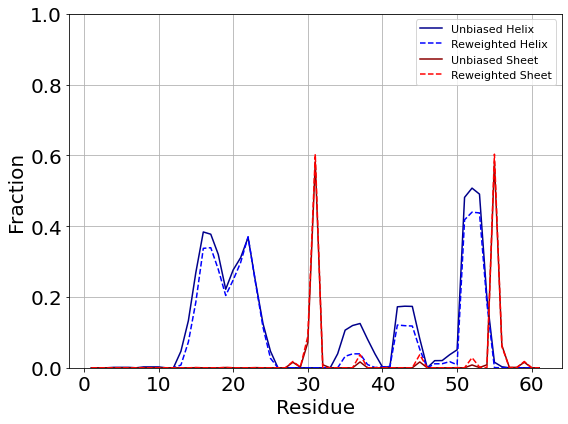

In [29]:
helix_prop = dsspH
sheet_prop = dsspE
Hprop = np.sum(helix_prop, axis=0).astype(float)/len(helix_prop)
Eprop = np.sum(sheet_prop, axis=0).astype(float)/len(sheet_prop)

reweight_Hprop = []
reweight_Eprop = []
for i in range(0, len(Hprop)):
    reweight_Hprop.append(np.dot(helix_prop[:, i], weights_norm))
    reweight_Eprop.append(np.dot(sheet_prop[:, i], weights_norm))

plt.figure(figsize=(8,6))
plt.plot(hres_renum, Hprop, color='darkblue', label='Unbiased Helix')
plt.ylim(0, 1.0)
plt.plot(hres_renum, reweight_Hprop, color='blue',
         label='Reweighted Helix', linestyle='dashed')
plt.plot(hres_renum, Eprop, color='darkred', label='Unbiased Sheet')
plt.plot(hres_renum, reweight_Eprop, color='red',
         label='Reweighted Sheet', linestyle='dashed')
plt.xlabel('Residue', size=20)
plt.ylabel('Fraction', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=11)
plt.grid()
# np.savetxt('%s/Hprop.reweight.dat' %
#            outdir, np.column_stack((hres_renum, reweight_Hprop)))
# np.savetxt('%s/Eprop.reweight.dat' %
#            outdir, np.column_stack((hres_renum, reweight_Eprop)))

# plt.savefig('%s/SS.reweight.png' % outdir)
# plt.show()
# plt.clf()

In [30]:
file_1='/home/jaya/work/analysis_trajectories/p53/meta_D_metaI/colvar.dat'
colvar=np.loadtxt(file_1,comments=['@','#'])

In [36]:
print("Number of CV's : ", colvar.shape[1]-2)

Number of CV's :  6


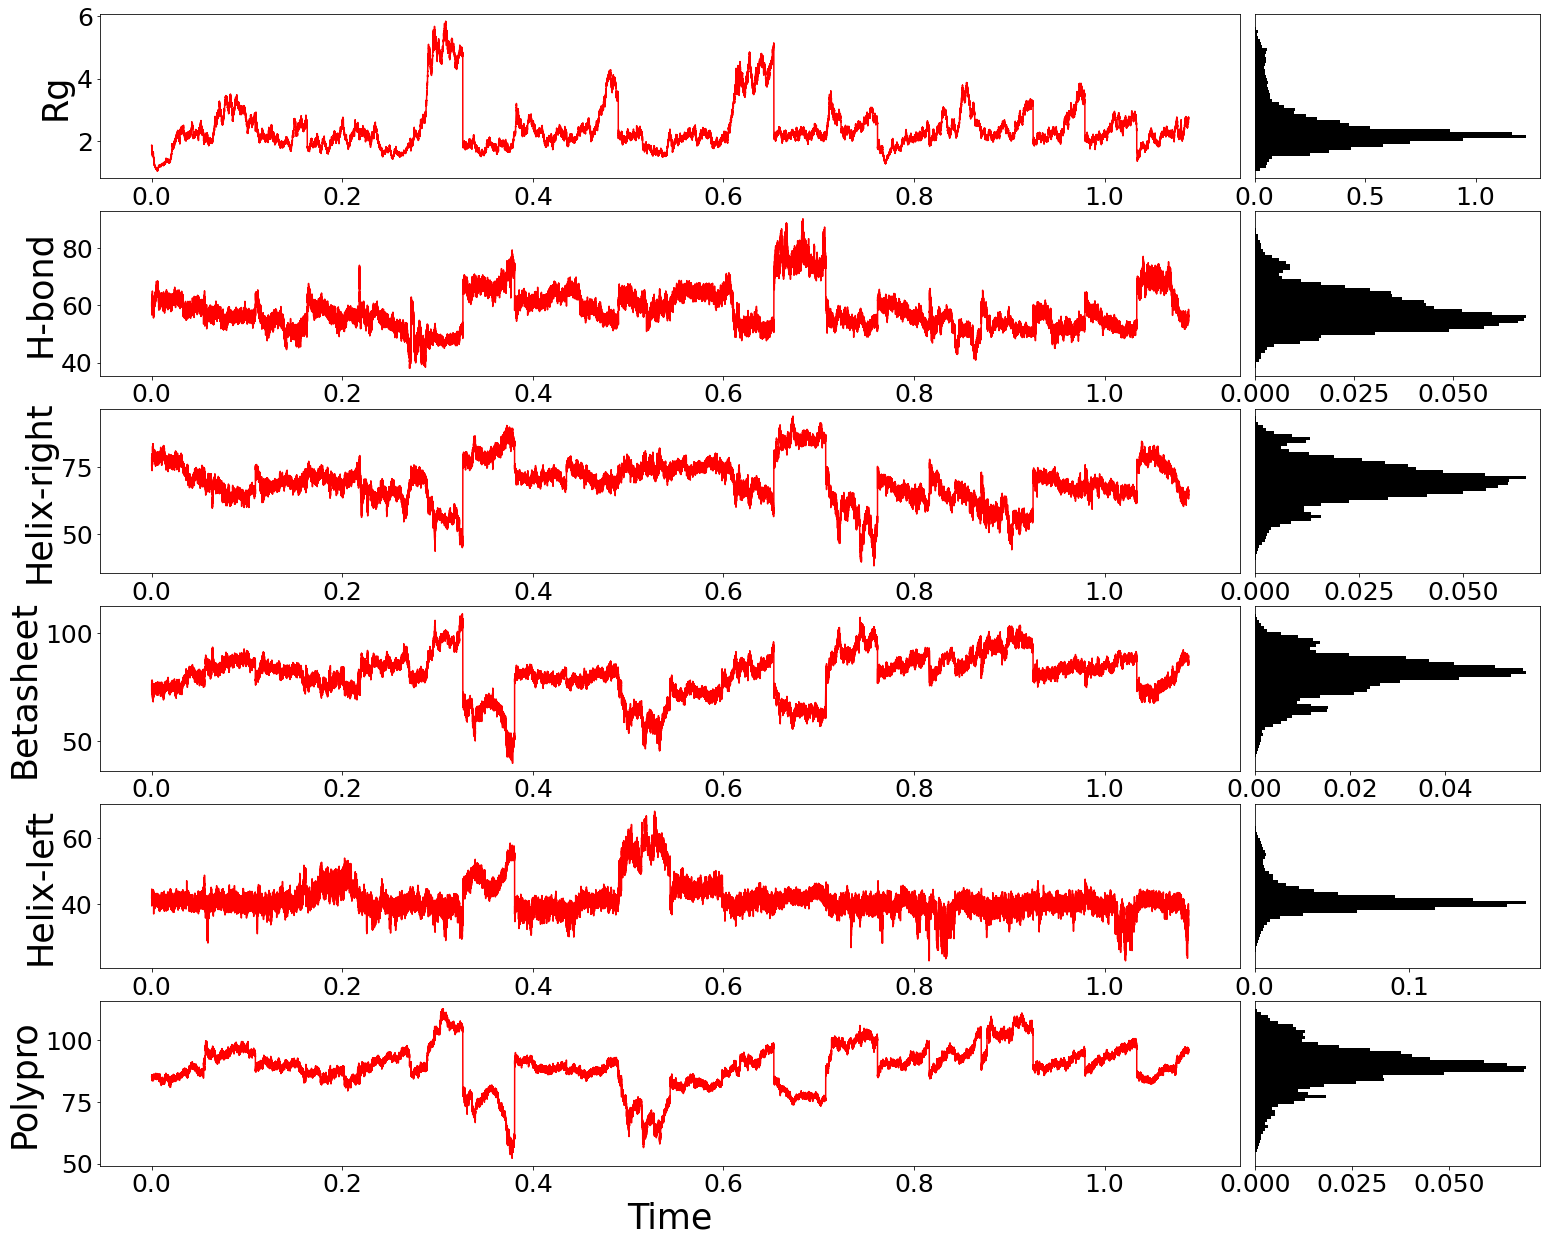

In [43]:
height_=[1]*(num_cvs-1)

label={'1':'Rg', '2':'H-bond', '3':'Helix-right', '4':'Betasheet', '5':'Helix-left', '6':'Polypro'}

f, ax = plt.subplots(num_cvs-1,2,figsize=(25,20),
                     gridspec_kw={'width_ratios':[4,1], 'height_ratios':height_, 'left':0.1, 'right':0.9, 
                                  'bottom':0.1, 'top':0.9,'wspace':0.02, 'hspace':0.2},sharey=False)

for i in range(num_cvs-1):
    

        
    ax[i,0].get_shared_y_axes().join(ax[i,0],ax[i,1])
    ax[i,0].plot(colvar.T[0]/10**5, colvar.T[i+1],color='r')
#    ax[i,0].set_ylim((min(colvar.T[i+1])-0.2),(max(colvar.T[i+1])+0.2))
    ax[i,0].set_ylabel(label[str(i+1)],size=35)
    ax[i,0].set_xlabel("Time",size=35)
    ax[i,0].tick_params(labelsize=25)
    
#     for j in range(16):
#         ax[i,0].axvline(x=trj_frames[str(j)][1]/10**5, color='black', linewidth=3, linestyle='--')
    
    ax[i,1].hist(colvar.T[i+1],orientation='horizontal',bins=50,density=True,color='black')
#    ax[i,1].set_xlim(0,0.7)
    ax[i,1].set_yticks([])
    ax[i,1].tick_params(labelsize=25)
    
#plt.tight_layout()

plt.savefig(out_dir+'cv_plot.png',dpi=310)

plt.show()

In [49]:
import datetime
 
startTime = datetime.datetime.now()

contact_maps = []
contact_distances = []
for i in range(0, 61):
    contact_map = []
    contact_distance = []
    for j in range(0, 61):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
    
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

endTime = datetime.datetime.now()
 
print("Time taken for contact map (prot) : ", endTime - startTime)

startTime = datetime.datetime.now()

# Make contact map
contact_maps = []
contact_distances = []
for i in range(0, 61):
    contact_map = []
    contact_distance = []
    for j in range(0, 61):
        if i == j:
            contacts = 0
        else:
            
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)

            distance = np.dot(array[:,0],weights_norm)
            contact_distance.append(distance)
            contact = np.where(np.array(array) < 1.2, 1, 0)

            contacts = np.dot(contact[:,0],weights_norm)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
    
final_map_re = np.asarray(contact_maps).astype(float)
final_distance_re = np.asarray(contact_distances).astype(float)

endTime = datetime.datetime.now()
 
print("Time taken for re-weighted contact map (prot) : ", endTime - startTime)

Time taken for contact map (prot) :  0:03:50.115029
Time taken for re-weighted contact map (prot) :  0:05:58.349454


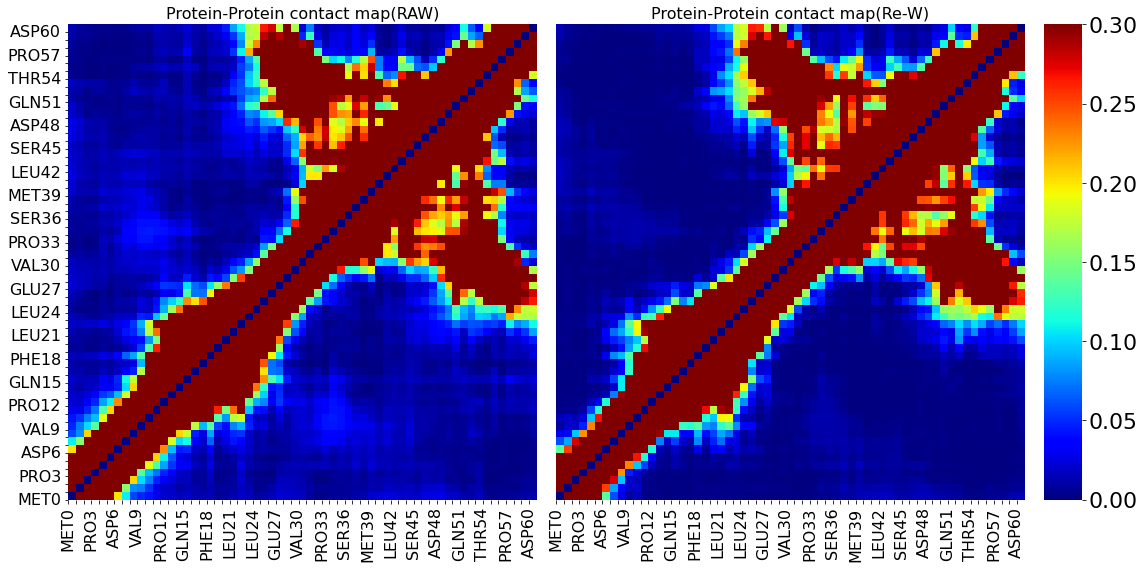

In [50]:
sequence=  ['MET0', '', '', 'PRO3', '', '', 'ASP6', '', '', 'VAL9', '', '',\
       'PRO12', '', '', 'GLN15', '', '', 'PHE18', '', '', 'LEU21', '', '',\
       'LEU24', '', '', 'GLU27', '', '', 'VAL30', '', '', 'PRO33', '', '',\
       'SER36', '', '', 'MET39', '', '', 'LEU42', '', '', 'SER45', '', '',\
       'ASP48', '', '', 'GLN51', '', '', 'THR54', '', '', 'PRO57', '', '',\
       'ASP60']


f,(ax1,ax2, axcb) = plt.subplots(1,3, gridspec_kw={'width_ratios':[1,1,0.08]},figsize=(16,8))

ax1.get_shared_y_axes().join(ax1,ax2)
g1 = sns.heatmap(final_map,cmap="jet",cbar=False,ax=ax1, vmin=0.0, vmax=0.3)
g1.set_xticks(range(61), sequence, rotation=90, size=16)
g1.set_yticks(range(0, 61), sequence,rotation=0, size=16)
g1.set_ylabel('')
g1.set_xlabel('')
g1.invert_yaxis()
#g1.grid(which='both', alpha=0.5)
g1.set_title("Protein-Protein contact map(RAW)", size=16)

g2 = sns.heatmap(final_map_re,cmap="jet",ax=ax2, cbar_ax=axcb, vmin=0.0, vmax=0.3)
g2.set_xticks(range(61), sequence, rotation=90, size=16)
g2.set_ylabel('')
g2.set_xlabel('')
g2.invert_yaxis()
#g2.grid(which='both',alpha=0.5)
g2.set_yticks([])
g2.set_title("Protein-Protein contact map(Re-W)", size=16)


# may be needed to rotate the ticklabels correctly:
# for ax in [g1,g2]:
    
#     ax.set_xticklabels(sequence, rotation=90)
#     ax.set_xticks()
#     tly = ax.get_yticklabels()
#     ax.set_yticklabels(tly, rotation=0)


axcb.tick_params(labelsize=22)
plt.tight_layout()

plt.savefig('contact_map_combined.png',dpi=210)

In [ ]:
colvar.T

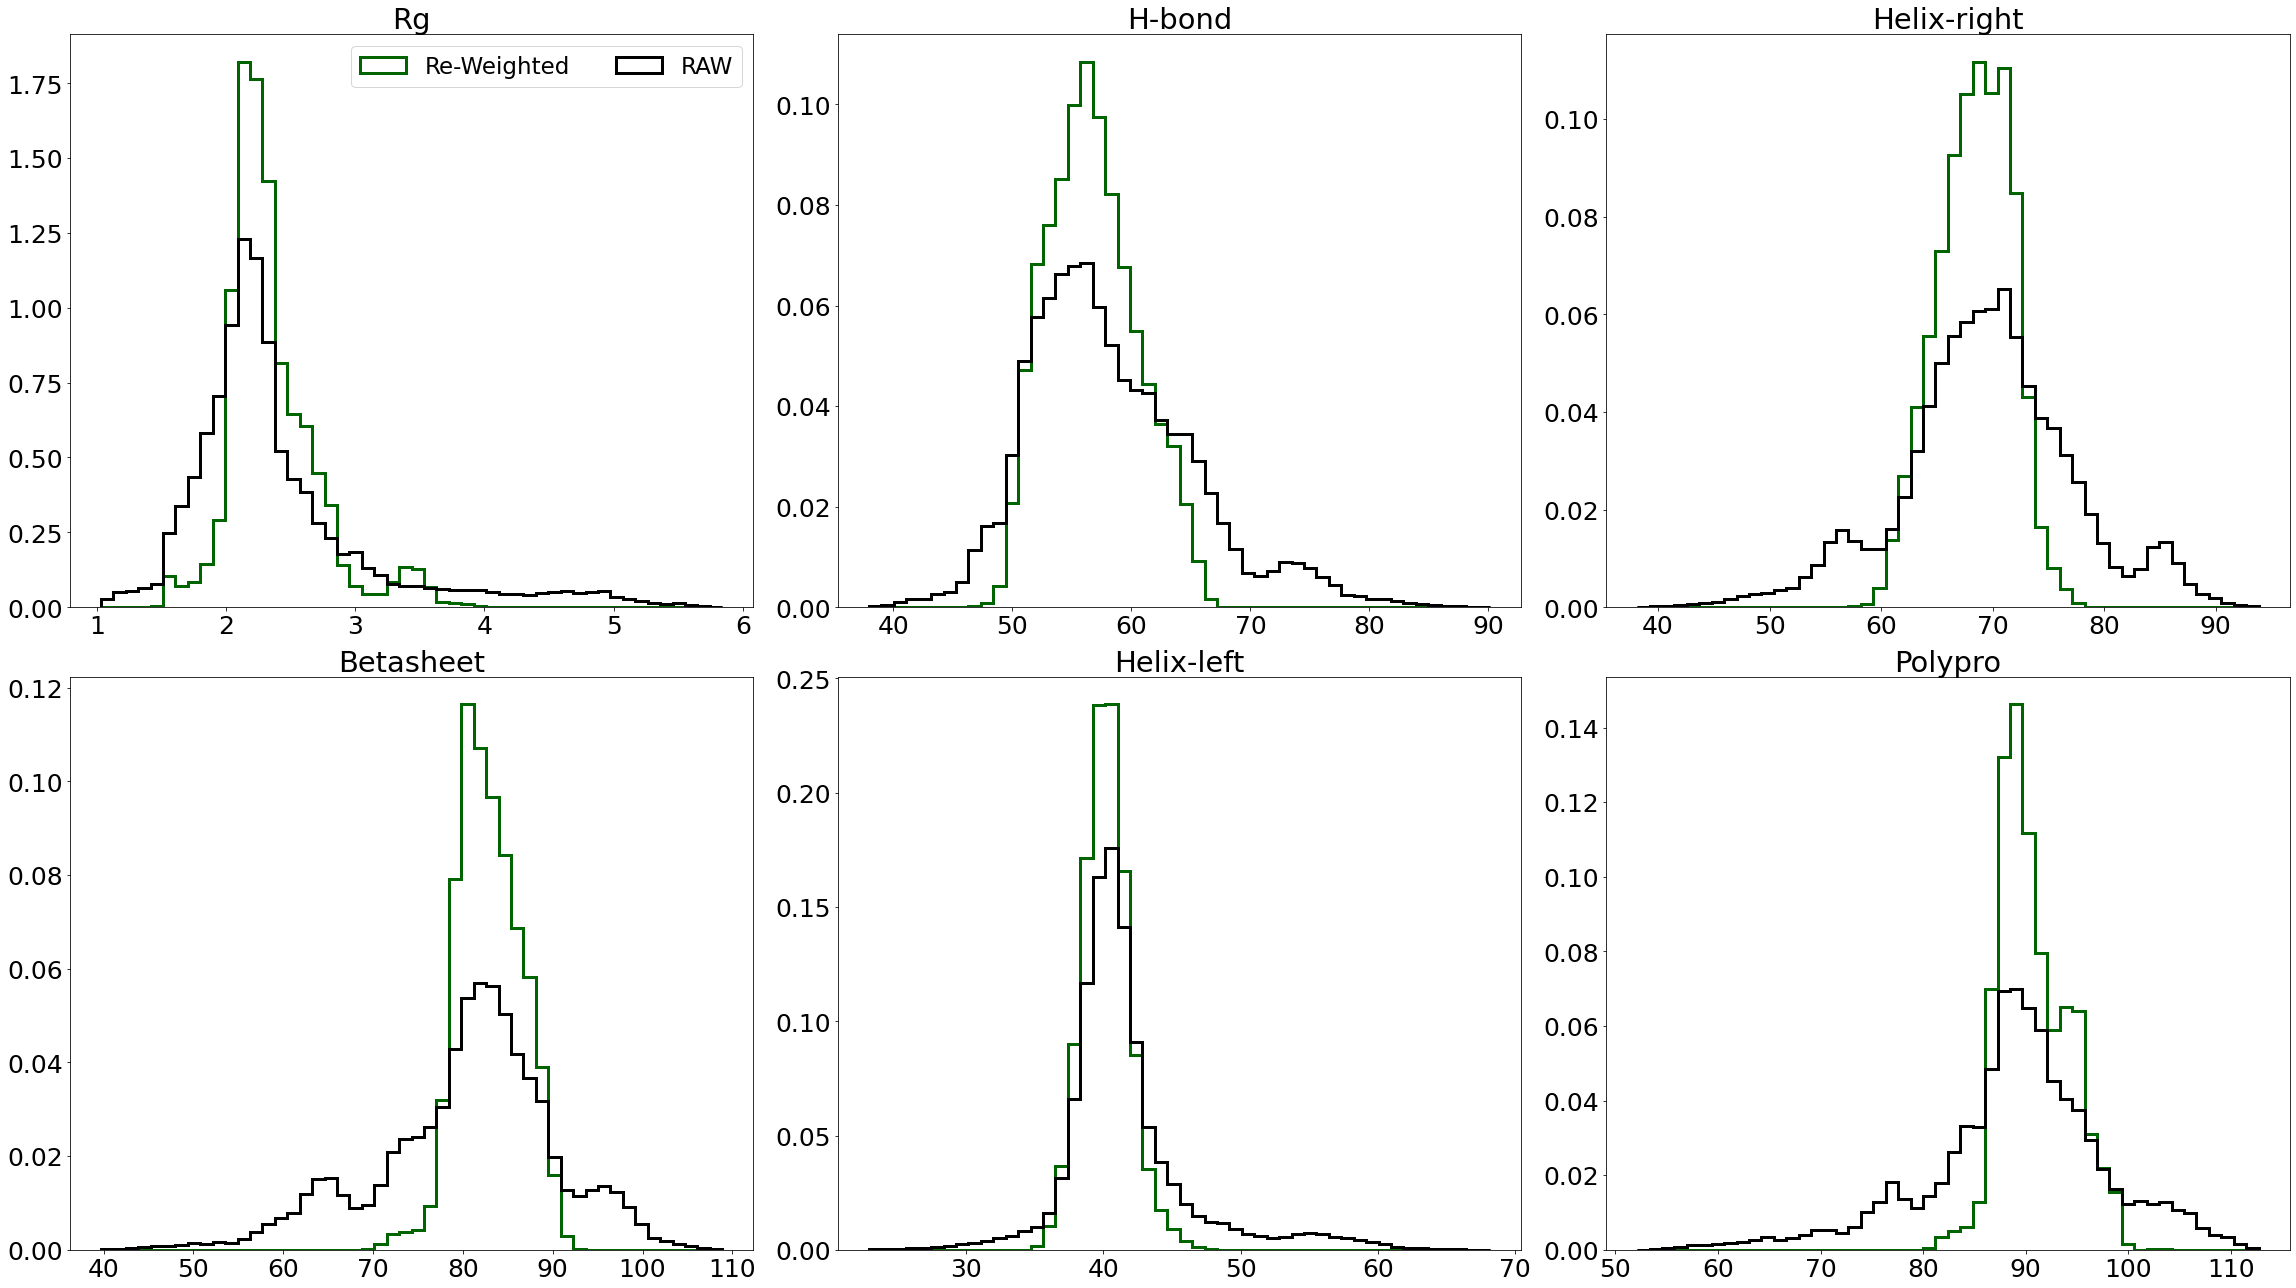

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(32, 18), sharex=False, sharey=False)

label={'1':'Rg', '2':'H-bond', '3':'Helix-right', '4':'Betasheet', '5':'Helix-left', '6':'Polypro'}

for i in range(6):
    p, q = np.unravel_index(i,(2,3))
    
    ax[p,q].hist(colvar.T[i+1],bins=50,density=True,color='darkgreen', linewidth=3,
                    histtype='step',weights=weights_norm,label='Re-Weighted')
    
    ax[p,q].hist(colvar.T[i+1],bins=50,density=True,color='black', linewidth=3,
                    histtype='step',label='RAW')
        
    ax[p,q].tick_params(labelsize=25)
    ax[p,q].set_title(str(label[str(i+1)]),size=29)
        
ax[0,0].legend(loc=1,prop={'size': 23},ncol=2)
plt.tight_layout()

/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)


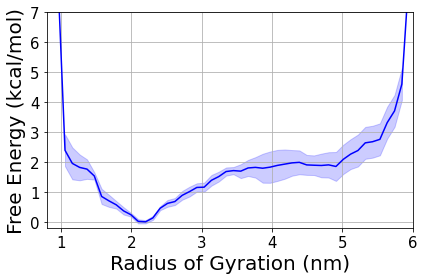

In [69]:
dG, bin_centers, ferr = free_energy_1D_blockerror(colvar.T[1], 300, 0.8, 6.0, 50, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 7)
plt.xlim(0.8, 6.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.grid()
#np.savetxt(outdir+'rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
#plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()

/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)


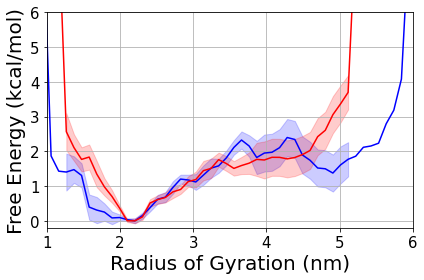

In [84]:
half=int(colvar.T[0].shape[0]/2)

dG1, bin_centers, ferr = free_energy_1D_blockerror(
    colvar.T[1][0:half], 300, 0.8, 6.0, 50, 5)
dG2, bin_centers, ferr = free_energy_1D_blockerror(
    colvar.T[1][half:-1], 300, 0.8, 6.0, 50, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue')
sns.lineplot(x=bin_centers, y=dG2, color='red')

plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr, dG2+ferr, color='red', alpha=0.2)

plt.ylim(-0.2, 6)
plt.xlim(1.0, 6.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.grid()
plt.show()

In [79]:
colvar.T[0].shape[0]/2

54410.5

/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)
/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)
/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)
/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)
/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)
/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)
/tmp/ipykernel_23588/4205608122.py:64: RuntimeWarning: invalid value encountered in true_divide
  ferr = -(0.001987*T)*(error / average)
/tmp/ipykernel_23588/4205608122.py:64: Ru

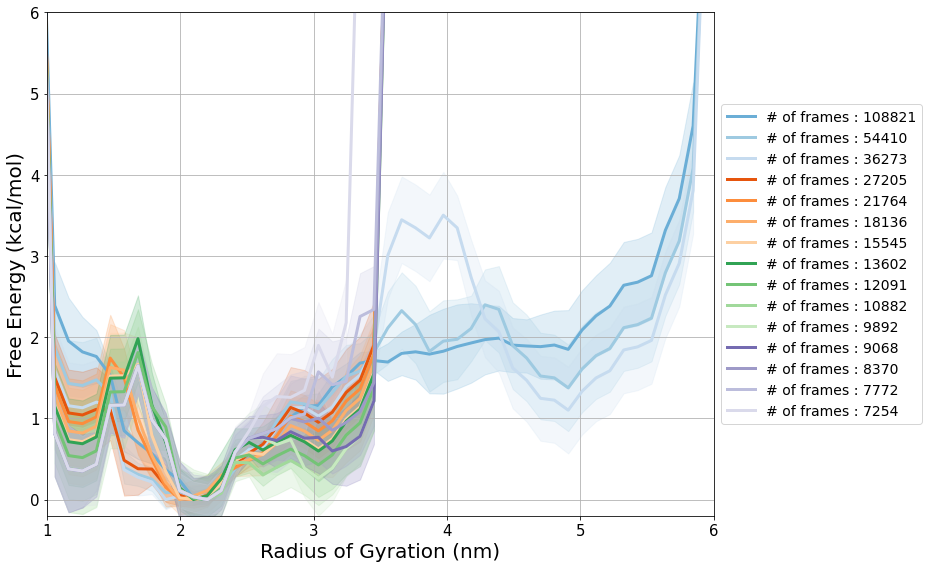

In [103]:
plt.figure(figsize=(13,8))

for i in range(1,16):
    
    half=int(colvar.T[0].shape[0]/i)
    
    dG1, bin_centers, ferr = free_energy_1D_blockerror(
        colvar.T[1][0:half], 300, 0.8, 6.0, 50, 5)

    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(i), linewidth=3,label="# of frames : "+str(half))

    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(i), alpha=0.2)

plt.ylim(-0.2, 6)
plt.xlim(1.0, 6.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.grid()
plt.show()